In [54]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from FCMAE_model import FCMAE
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc


/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


True

In [55]:
# import wandb

# wandb.init(project="XGBoost for time series classification", config={
#     "model": "XGBoost",
#     "input_length": 12000,
#     "batch_size": batch_size,
#     "lr": 1e-3,
#     "epochs": 10,
#     "dropout": 0.2,
#     "kernel_size": 7,
#     "channels": [32, 64],
# })


In [56]:
train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])


124
32
{'record_name': np.str_('Hopper-2022_08_24_06_55_46-0000010181-0001'), 'signal': array([[ -8.77326634],
       [-16.30170858],
       [-12.15312614],
       ...,
       [  1.94513686],
       [  0.52803341],
       [  2.90890496]]), 'fs': 20, 'preterm': 1}


In [57]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")
print(train_windows.shape, train_labels.shape)

Train label distribution:
  Term (0): 319
  Preterm (1): 752

Test label distribution:
  Term (0): 306
  Preterm (1): 593
(1071, 12000) (1071,)


Test Accuracy: 65.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.07       306
           1       0.66      0.98      0.79       593

    accuracy                           0.66       899
   macro avg       0.58      0.51      0.43       899
weighted avg       0.61      0.66      0.55       899



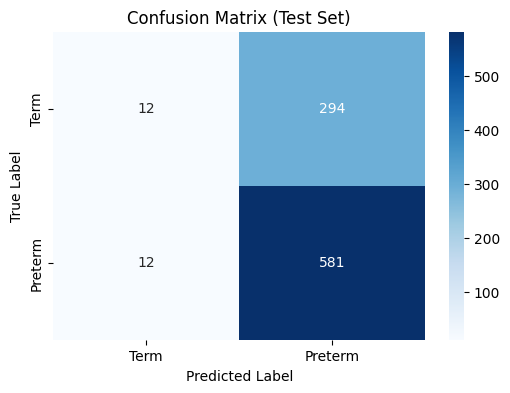

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,        # number of trees
    max_depth=10,            # max tree depth to control overfitting
    class_weight='balanced', # handle class imbalance
    random_state=42,
    n_jobs=-1                # use all CPU cores
)

# Fit the model on the full training set
rf_model.fit(train_windows, train_labels)

# Predict on the test set
test_preds = rf_model.predict(test_windows)

# Evaluate
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Term", "Preterm"], yticklabels=["Term", "Preterm"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


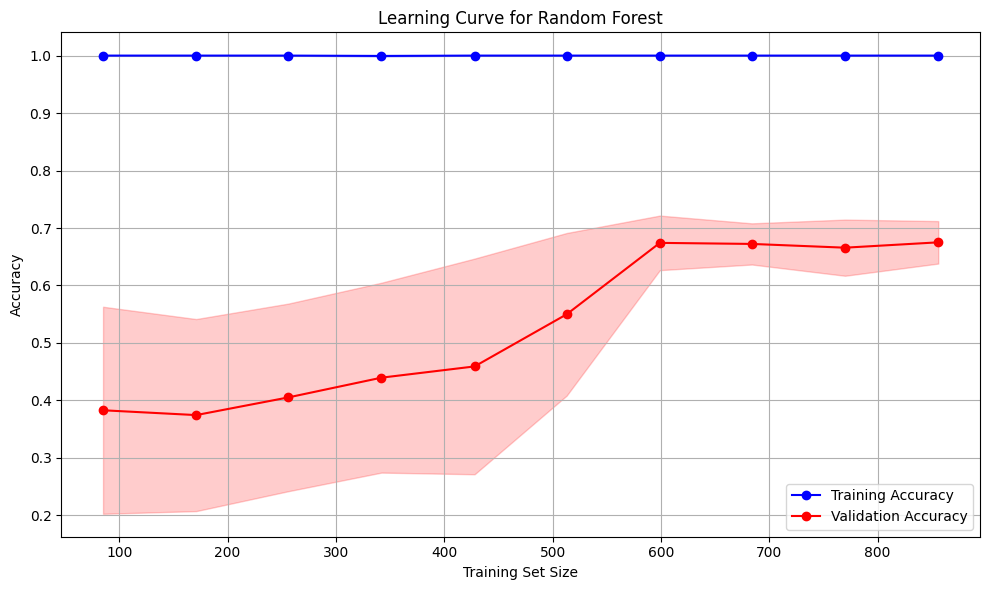

In [62]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=train_windows,
    y=train_labels,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, test_mean, 'o-', label="Validation Accuracy", color="red")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
path = os.path.join(models_path, 'FCMAE_best_multiple_encoder_cpu.pth')

# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=128, num_blocks=5, kernel_size=9)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# No need to reshape, already correct shape
X_train, y_train = train_windows, train_labels
X_test, y_test = test_windows, test_labels


model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=train_label_counts[0] / train_label_counts[1],
    n_estimators=500,  # number of boosting rounds (like epochs), 
    reg_alpha=1.0,
    reg_lambda=1.0,
    max_depth=3,
    learning_rate=0.01
)

# Provide validation set to track loss
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Retrieve evaluation results
results = model.evals_result()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Test Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Train/Test Loss per Boosting Round')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming train_windows and train_labels are already loaded
# Split the training data into 80% training and 20% validation
train_windows_split, val_windows_split, train_labels_split, val_labels_split = train_test_split(
    train_windows, train_labels, test_size=0.2, random_state=42
)

# Print the split sizes for verification
print(f"Train set size: {train_windows_split.shape[0]} samples")
print(f"Validation set size: {val_windows_split.shape[0]} samples")
print(train_windows_split.shape)
print(train_labels_split.shape)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# No need to reshape, already correct shape
X_train, y_train = train_windows_split, train_labels_split
X_test, y_test = val_windows_split, val_labels_split


model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=train_label_counts[0] / train_label_counts[1],
    n_estimators=500,  # number of boosting rounds (like epochs), 
    reg_alpha=1.0,
    reg_lambda=1.0,
    max_depth=3,
    learning_rate=0.01
)

# Provide validation set to track loss
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Retrieve evaluation results
results = model.evals_result()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Test Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Train/Test Loss per Boosting Round')
plt.legend()
plt.grid(True)
plt.show()
